In [7]:
from TrainLGBM import GetPreprocessedData

ruleset_names, all_data = GetPreprocessedData(split_agent_features = True)

Data shape: (233234, 597)


/media/shared/ExpansionDrive2/TreeSearch/TrainLGBM.py:30: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  df = df.with_columns([pl.col(col).cast(pl.Categorical) for col in df.columns if col[:6] in AGENT_COLS])


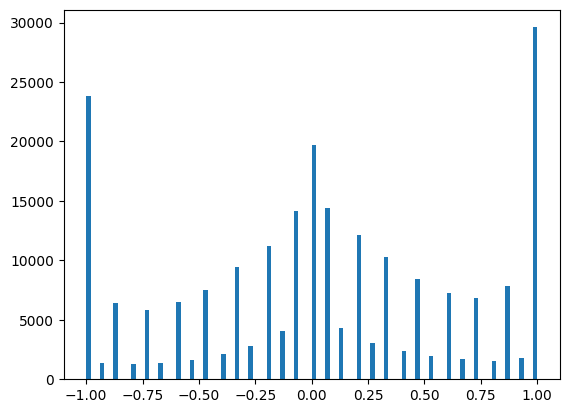

In [8]:
from matplotlib import pyplot as plt

all_x = all_data.drop(['utility_agent1'], axis=1)
all_y = all_data['utility_agent1']

plt.hist(all_y, bins=100)
plt.show()

In [9]:
all_classification_y = (all_y > 0.999).astype(int) - (all_y < -0.999).astype(int)
print(sum(all_classification_y == 1))
print(sum(all_classification_y == -1))

29604
23846


In [10]:
from lightgbm import LGBMClassifier, LGBMRegressor
import lightgbm as lgbm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import root_mean_squared_error
import numpy as np

# lgbm_hyperparameters = {
#     'num_iterations': 10000,
#     'learning_rate': 0.03184567466358953,
#     'num_leaves': 196,
#     'max_depth': 17,
#     'min_child_samples': 94,
#     'subsample': 0.8854325308371437,
#     'colsample_bytree': 0.9612980174610098,
#     'colsample_bynode': 0.6867101420064379,
#     'reg_alpha': 1.593152807295967e-05,
#     'reg_lambda': 4.8636580199114866e-08,
#     'extra_trees': False
# }

# lgbm_hyperparameters = {
#     "num_iterations": 10000,
#     "learning_rate": 0.02556180399737767,
#     "num_leaves": 247,
#     "max_depth": 16,
#     "min_child_samples": 72,
#     "subsample": 0.6261097426808137,
#     "colsample_bytree": 0.8480868413996958,
#     "reg_alpha": 3.7437548643071,
#     "reg_lambda": 0.0010293013793948255,
#     'verbosity': 0
# }

lgbm_hyperparameters = {
    'num_iterations': 10000,
    'verbosity': 0
}

FOLD_COUNT = 5
group_kfold = GroupKFold(n_splits=FOLD_COUNT)
folds = list(group_kfold.split(all_x, all_y, groups=ruleset_names))

rmse_scores = []
for fold_index, (train_index, test_index) in enumerate(folds):
    print(f'Fold {fold_index+1}/{FOLD_COUNT}...')

    # TRAIN CLASSIFICATION MODEL.
    train_classification_x = all_x.iloc[train_index]
    train_classification_y = all_classification_y.iloc[train_index]

    test_classification_x = all_x.iloc[test_index]
    test_classification_y = all_classification_y.iloc[test_index]

    classification_model = LGBMClassifier(**lgbm_hyperparameters)
    classification_model.fit(
        train_classification_x, 
        train_classification_y,
        eval_set=[(test_classification_x, test_classification_y)],
        eval_metric='logloss',
        callbacks=[lgbm.early_stopping(50)]
    )

    # TRAIN REGRESSION MODEL.
    train_regression_mask = (train_classification_y == 0)
    train_regression_x = all_x.iloc[train_index][train_regression_mask]
    train_regression_y = all_y.iloc[train_index][train_regression_mask]

    test_regression_mask = (test_classification_y == 0)
    test_regression_x = all_x.iloc[test_index][test_regression_mask]
    test_regression_y = all_y.iloc[test_index][test_regression_mask]

    regression_model = LGBMRegressor(**lgbm_hyperparameters)
    regression_model.fit(
        train_regression_x,
        train_regression_y,
        eval_set=[(test_regression_x, test_regression_y)],
        eval_metric='rmse',
        callbacks=[lgbm.early_stopping(50)]
    )

    # EVALUATE MODEL.
    full_test_x = all_x.iloc[test_index]
    full_test_y = all_y.iloc[test_index]

    classification_predictions = classification_model.predict_proba(full_test_x)
    regression_predictions = regression_model.predict(full_test_x)

    full_predictions = (classification_predictions[:, 0] * -1) + (classification_predictions[:, 1] * regression_predictions) + (classification_predictions[:, 2] * 1)
    rmse = root_mean_squared_error(full_test_y, full_predictions)
    print(f'RMSE: {rmse}')
    rmse_scores.append(rmse)

print(f'Average RMSE: {np.mean(rmse_scores)}')


Fold 1/5...


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's multi_logloss: 0.36567


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[978]	valid_0's rmse: 0.378354	valid_0's l2: 0.143152
RMSE: 0.43719483758206135
Fold 2/5...


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.355603


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[603]	valid_0's rmse: 0.379262	valid_0's l2: 0.143839
RMSE: 0.45261191750261626
Fold 3/5...


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.388639


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1121]	valid_0's rmse: 0.368983	valid_0's l2: 0.136148
RMSE: 0.4460798507335665
Fold 4/5...


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.354528


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1399]	valid_0's rmse: 0.378674	valid_0's l2: 0.143394
RMSE: 0.42630890036549685
Fold 5/5...


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's multi_logloss: 0.332256


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[690]	valid_0's rmse: 0.371046	valid_0's l2: 0.137675
RMSE: 0.43141033962876496
Average RMSE: 0.4387211691625012


In [11]:
print(f'Average RMSE: {np.mean(rmse_scores)}')

Average RMSE: 0.4387211691625012


In [12]:
from lightgbm import LGBMClassifier, LGBMRegressor
import lightgbm as lgbm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import root_mean_squared_error
import numpy as np

# lgbm_hyperparameters = {
#     'num_iterations': 10000,
#     'learning_rate': 0.03184567466358953,
#     'num_leaves': 196,
#     'max_depth': 17,
#     'min_child_samples': 94,
#     'subsample': 0.8854325308371437,
#     'colsample_bytree': 0.9612980174610098,
#     'colsample_bynode': 0.6867101420064379,
#     'reg_alpha': 1.593152807295967e-05,
#     'reg_lambda': 4.8636580199114866e-08,
#     'extra_trees': False
# }

# lgbm_hyperparameters = {
#     "num_iterations": 10000,
#     "learning_rate": 0.02556180399737767,
#     "num_leaves": 247,
#     "max_depth": 16,
#     "min_child_samples": 72,
#     "subsample": 0.6261097426808137,
#     "colsample_bytree": 0.8480868413996958,
#     "reg_alpha": 3.7437548643071,
#     "reg_lambda": 0.0010293013793948255,
#     'verbosity': 0
# }

lgbm_hyperparameters = {
    'num_iterations': 10000,
    'verbosity': 0
}

FOLD_COUNT = 5
group_kfold = GroupKFold(n_splits=FOLD_COUNT)
folds = list(group_kfold.split(all_x, all_y, groups=ruleset_names))

rmse_scores = []
for fold_index, (train_index, test_index) in enumerate(folds):
    print(f'Fold {fold_index+1}/{FOLD_COUNT}...')

    # TRAIN REGRESSION MODEL.
    train_regression_x = all_x.iloc[train_index]
    train_regression_y = all_y.iloc[train_index]

    test_regression_x = all_x.iloc[test_index]
    test_regression_y = all_y.iloc[test_index]

    regression_model = LGBMRegressor(**lgbm_hyperparameters)
    regression_model.fit(
        train_regression_x,
        train_regression_y,
        eval_set=[(test_regression_x, test_regression_y)],
        eval_metric='rmse',
        callbacks=[lgbm.early_stopping(50)]
    )

    # EVALUATE MODEL.
    predictions = regression_model.predict(test_regression_x)
    rmse = root_mean_squared_error(test_regression_y, predictions)
    print(f'RMSE: {rmse}')
    rmse_scores.append(rmse)

print(f'Average RMSE: {np.mean(rmse_scores)}')


Fold 1/5...


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1470]	valid_0's rmse: 0.442911	valid_0's l2: 0.19617
RMSE: 0.4429107436045136
Fold 2/5...


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[809]	valid_0's rmse: 0.453057	valid_0's l2: 0.205261
RMSE: 0.453056858363277
Fold 3/5...


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[812]	valid_0's rmse: 0.458596	valid_0's l2: 0.21031
RMSE: 0.458595696203863
Fold 4/5...


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1276]	valid_0's rmse: 0.423019	valid_0's l2: 0.178945
RMSE: 0.42301946137062224
Fold 5/5...


/home/jday/miniconda3/envs/torch2.3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1580]	valid_0's rmse: 0.423277	valid_0's l2: 0.179164
RMSE: 0.4232771707877859
Average RMSE: 0.4401719860660124
